In [ ]:
!pip install datasets

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import learning_curve

In [ ]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [6]:
train_df = pd.DataFrame(ds["train"])
test_df = pd.DataFrame(ds["test"])

print(train_df.head())
print(test_df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


In [7]:
train_df['label'].value_counts()

,count
label,
0,12500
1,12500


In [8]:
test_df.shape

(25000, 2)

In [9]:
tokenizer=ToktokTokenizer()
nltk.download('stopwords')
stop_words_list = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words_list.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Removing the html strips, square brackets, noisy text

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word not in stop_words_list]
    return " ".join(filtered_words)

def denoise_text(text):
    text = strip_html(text)
    text = clean_text(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    return text

train_df['text']=train_df['text'].apply(denoise_text)
test_df['text']=test_df['text'].apply(denoise_text)

In [12]:
test_df.head()

,text,label
0,love scifi willing put lot scifi moviestv usua...,0
1,worth entertainment value rental especially li...,0
2,totally average film semialright action sequen...,0
3,star rating saturday night friday night friday...,0
4,first let say havent enjoyed van damme movie s...,0


#Tfidf vectorizer

In [13]:
tv=TfidfVectorizer(min_df=1,max_df=1.0,use_idf=True,ngram_range=(1,3))

tv_train_reviews=tv.fit_transform(train_df['text'])

tv_test_reviews=tv.transform(test_df['text'])
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (25000, 4835440)
Tfidf_test: (25000, 4835440)


#Ensuring(double check) the labeling the sentient data and transformed sentiment data


In [14]:
lb=LabelBinarizer()

train_sentiments=lb.fit_transform(train_df['label'])
test_sentiments=lb.fit_transform(test_df['label'])

print(train_sentiments.shape)
print(test_sentiments.shape)

(25000, 1)
(25000, 1)


#Model - SVM

In [ ]:
from sklearn.svm import LinearSVC

svm_model_tfidf = LinearSVC(random_state=42)

train_sizes, train_scores, validation_scores = learning_curve(
    svm_model_tfidf, tv_train_reviews, train_sentiments.ravel(),
    cv=5, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(validation_scores, axis=1)
val_std = np.std(validation_scores, axis=1)

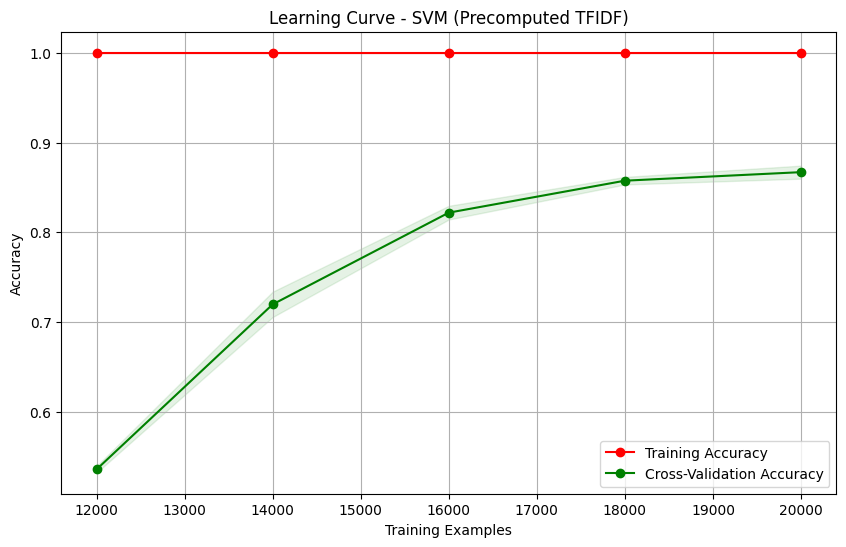

In [16]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-Validation Accuracy")

plt.title("Learning Curve - SVM (Precomputed TFIDF)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [17]:
svm_model_tfidf.fit(tv_train_reviews, train_sentiments.ravel())

svm_predictions = svm_model_tfidf.predict(tv_test_reviews)

final_svm_accuracy = accuracy_score(test_sentiments, svm_predictions)
print(f"SVM Final Accuracy: {final_svm_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(test_sentiments, svm_predictions, target_names=['Negative', 'Positive']))

SVM Final Accuracy: 89.02%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89     12500
    Positive       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



#Model - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

logreg_model.fit(tv_train_reviews, train_sentiments.ravel())

train_sizes, train_scores, val_scores = learning_curve(
    logreg_model, tv_train_reviews, train_sentiments.ravel(),
    cv=5, scoring="accuracy",
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

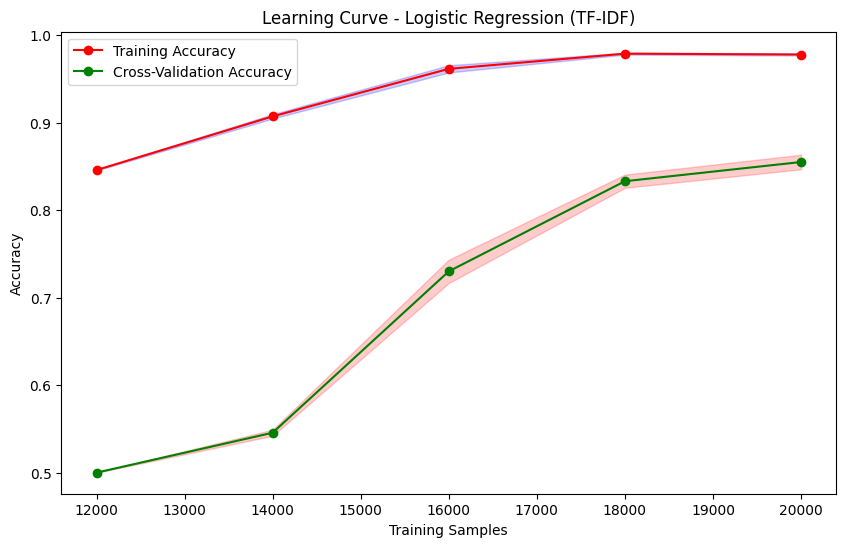

In [41]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="red")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-Validation Accuracy")

plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Logistic Regression (TF-IDF)")
plt.legend(loc="best")
plt.show()

In [42]:
logreg_preds = logreg_model.predict(tv_test_reviews)

logreg_accuracy = accuracy_score(test_sentiments, logreg_preds)
print(f"Logistic Regression Accuracy: {logreg_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(test_sentiments, logreg_preds, target_names=['Negative', 'Positive']))

Logistic Regression Accuracy: 87.22%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     12500
    Positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



#Model - CNN

In [ ]:
!pip install tensorflow

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

max_vocab_size = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [34]:
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=256, input_length=max_len),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

def lr_schedule(epoch):
    return 0.001 * (0.8 ** epoch)

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train_padded, np.array(train_sentiments),
    epochs=10, batch_size=32, validation_split=0.2,
    callbacks=[lr_scheduler, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 109ms/step - accuracy: 0.5779 - loss: 0.8955 - val_accuracy: 0.7572 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.8162 - loss: 0.4078 - val_accuracy: 0.7738 - val_loss: 0.4646 - learning_rate: 8.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.9031 - loss: 0.2633 - val_accuracy: 0.7694 - val_loss: 0.4870 - learning_rate: 6.4000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 113ms/step - accuracy: 0.9355 - loss: 0.1795 - val_accuracy: 0.8016 - val_loss: 0.4405 - learning_rate: 5.1200e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 109ms/step - accuracy: 0.9552 - loss: 0.1325 - val_accuracy: 0.6914 - val_loss: 0.7629 - learning_rate: 4.0960e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.9717 - loss: 0.0840 - val_accuracy: 0.8526 - val_loss: 0.4301 - learning_rate: 3.2768e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/

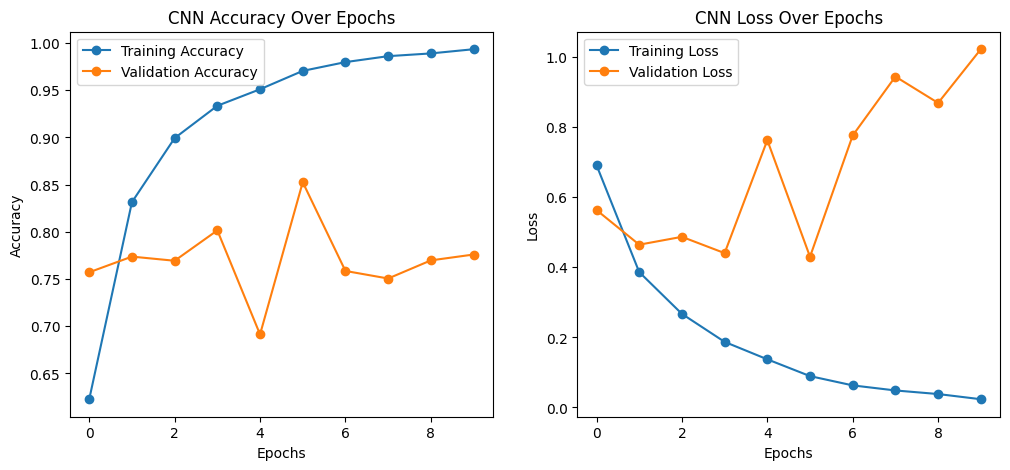

In [35]:
plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Training Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Over Epochs')
plt.legend()

plt.show()

In [36]:
test_loss, test_acc = cnn_model.evaluate(X_test_padded, np.array(test_sentiments))
print(f"CNN Test Accuracy: {test_acc * 100:.2f}%")

predictions_cnn = cnn_model.predict(X_test_padded)
y_pred_cnn = (predictions_cnn > 0.5).astype(int).flatten()

print("\nClassification Report:\n")
print(classification_report(test_sentiments, y_pred_cnn, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8532 - loss: 0.3630
CNN Test Accuracy: 85.94%
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     12500
    Positive       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



#Model - CNN + LSTM

In [37]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

# Define the CNN+LSTM hybrid model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_padded, np.array(train_sentiments),
                    epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 372ms/step - accuracy: 0.6285 - loss: 0.6630 - val_accuracy: 0.7110 - val_loss: 0.6540
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 374ms/step - accuracy: 0.8512 - loss: 0.3566 - val_accuracy: 0.6874 - val_loss: 0.7257
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 375ms/step - accuracy: 0.9277 - loss: 0.2024 - val_accuracy: 0.6228 - val_loss: 0.8638
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 389ms/step - accuracy: 0.9498 - loss: 0.1518 - val_accuracy: 0.7532 - val_loss: 0.6563
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 416ms/step - accuracy: 0.9719 - loss: 0.0959 - val_accuracy: 0.7934 - val_loss: 0.6267
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 377ms/step - accuracy: 0.9833 - loss: 0.0634 - val_accuracy: 0.7644 - val_loss: 0.8243
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 230s 369ms/step - accuracy: 0.9876 - loss: 0.0445 - val_accuracy: 0.7884 - val_loss: 0.8195
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 225s 360ms/step - accuracy: 0.9890 -

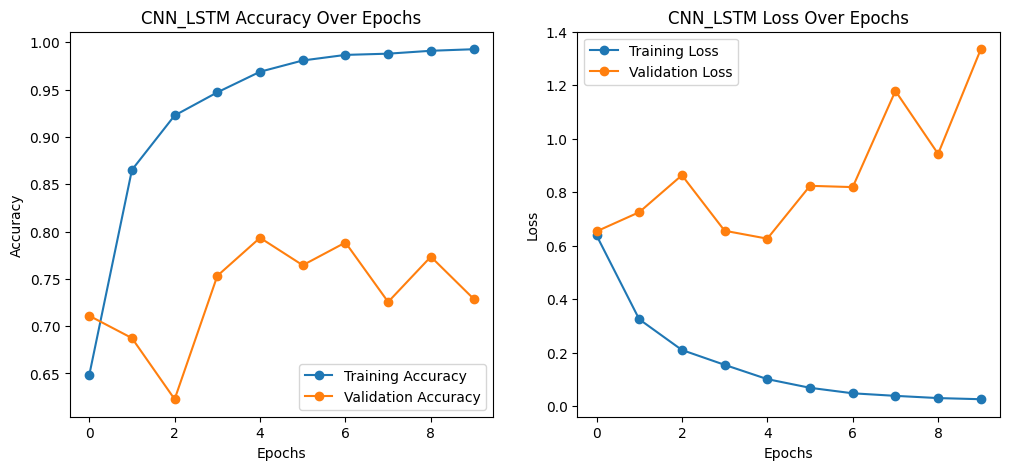

In [38]:
plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN_LSTM Accuracy Over Epochs')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Training Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN_LSTM Loss Over Epochs')
plt.legend()

plt.show()

In [39]:
cnn_lstm_loss, cnn_lstm_accuracy = model.evaluate(X_test_padded, np.array(test_sentiments))
print(f"Test Accuracy: {cnn_lstm_accuracy * 100:.2f}%")

cnn_lstm_preds = model.predict(X_test_padded)
cnn_lstm_preds = (cnn_lstm_preds > 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(test_sentiments, cnn_lstm_preds, target_names=["negative", "positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.8892 - loss: 0.4815
Test Accuracy: 83.48%
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.91      0.85     12500
    positive       0.90      0.76      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



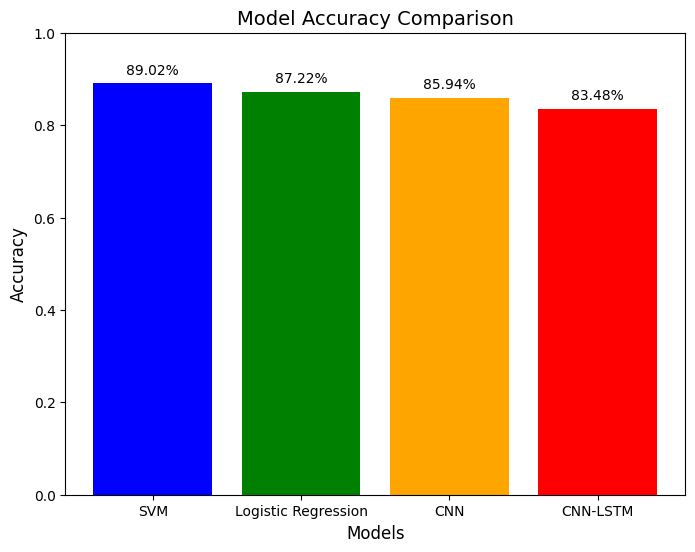

In [40]:
accuracies = [final_svm_accuracy, logreg_accuracy, test_acc, cnn_lstm_accuracy]
models = ['SVM', 'Logistic Regression', 'CNN', 'CNN-LSTM']

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc*100:.2f}%', ha='center', fontsize=10)

plt.ylim(0, 1)
plt.show()